### Import Necessary Libraries

In [803]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import minimize
import scipy.integrate as integrate

### Data

In [5]:
data = pd.read_csv("../data/BNBUSDT-1s-2024-10-30.csv", names=['start_time', 'open', 'high', 'low', 'close', 'vol', 'stop_time', 'quote_asset_vol', 'num_trades', 'taker_base_vol', 'taker_quote_vol', 'ignore'])
data = data.loc[:, 'start_time':'vol']
data['start_time'] = pd.to_datetime(data['start_time'], unit='ms')
data.set_index('start_time', inplace=True)
data

,open,high,low,close,vol
start_time,,,,,
2024-10-30 00:00:00,606.3,606.3,606.3,606.3,12.251
2024-10-30 00:00:01,606.3,606.3,606.3,606.3,0.059
2024-10-30 00:00:02,606.2,606.2,606.2,606.2,0.141
2024-10-30 00:00:03,606.2,606.2,606.2,606.2,0.072
2024-10-30 00:00:04,606.3,606.3,606.2,606.3,0.580
...,...,...,...,...,...
2024-10-30 23:59:55,595.6,595.6,595.6,595.6,0.000
2024-10-30 23:59:56,595.6,595.6,595.6,595.6,0.000
2024-10-30 23:59:57,595.6,595.6,595.6,595.6,0.000


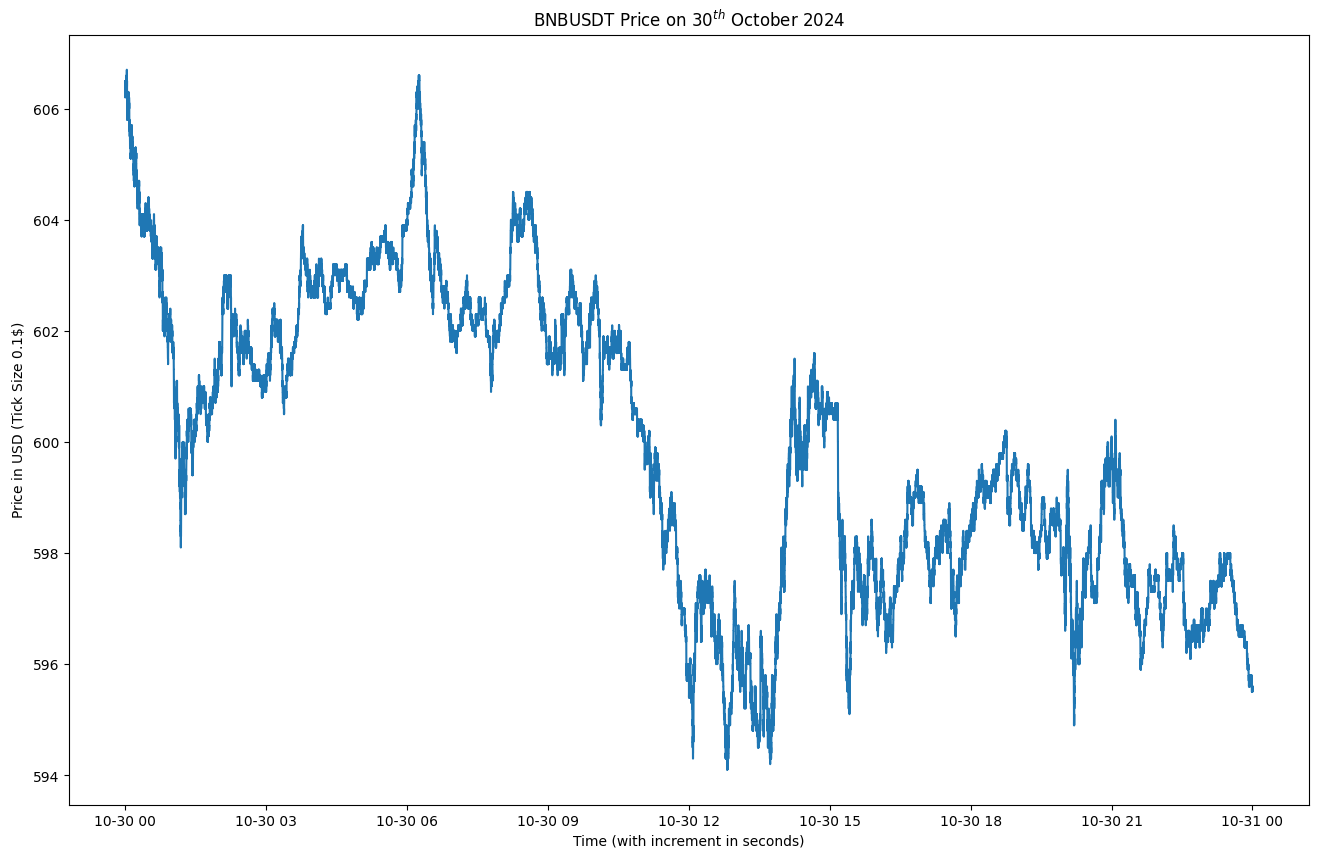

In [6]:
plt.figure(figsize=(16, 10))
plt.plot(data.close)
plt.title("BNBUSDT Price on $30^{th}$ October 2024")
plt.xlabel("Time (with increment in seconds)")
plt.ylabel("Price in USD (Tick Size $0.1\$$)")
plt.show()

In [920]:
(data.close.diff(1).round(1)*10).value_counts().index

Index([0.0, 1.0, -1.0, -2.0, 2.0, -3.0, 3.0, -4.0, 4.0, -5.0, 5.0, -6.0, 13.0,
       6.0],
      dtype='float64', name='close')

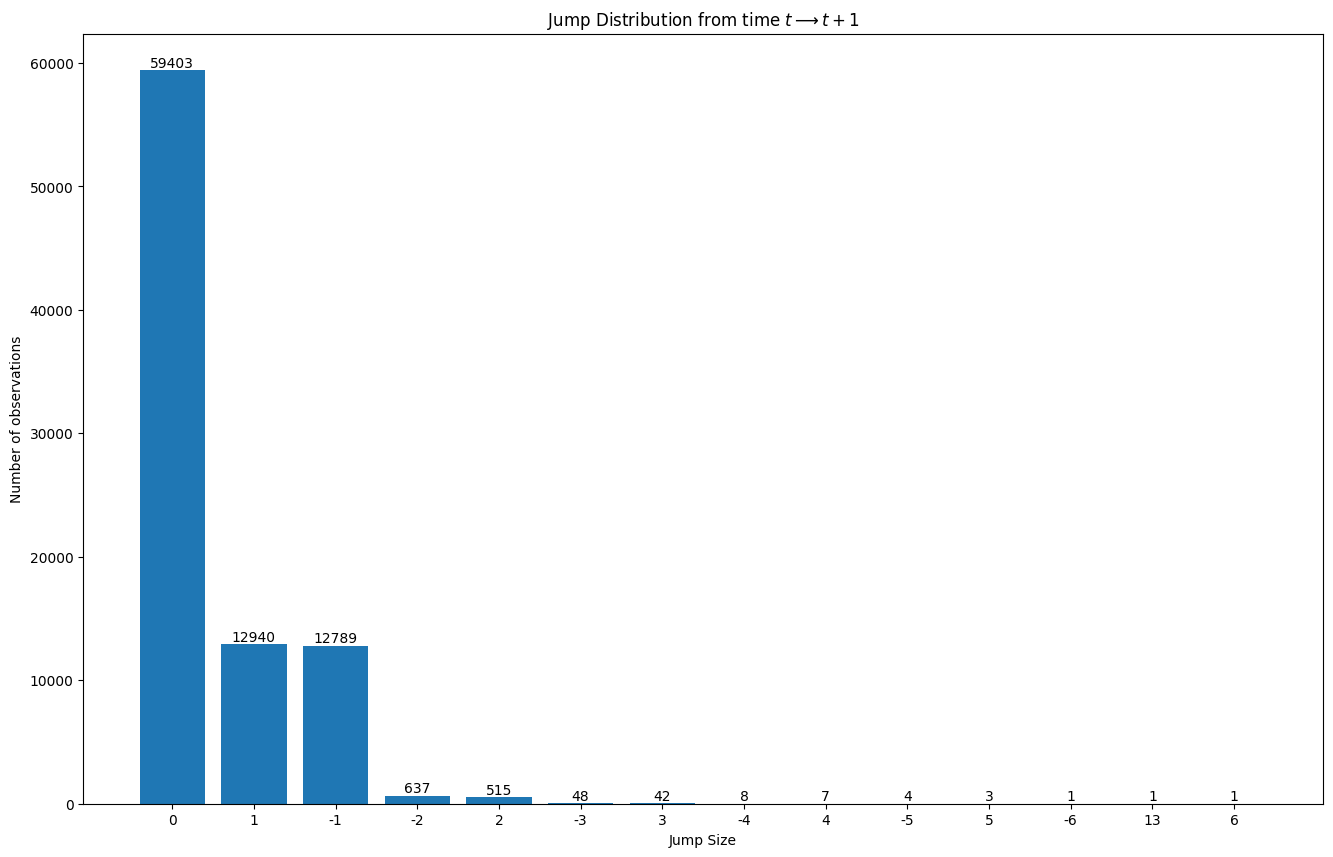

In [930]:
fig, ax = plt.subplots(figsize=(16, 10))
bars = ax.bar(
    np.arange(len((data.close.diff(1).round(1)*10).value_counts().index)), 
    (data.close.diff(1).round(1)*10).value_counts(), 
    tick_label=list(np.array((data.close.diff(1).round(1)*10).value_counts().index).astype(int)))
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, height, ha='center', va='bottom')
plt.title('Jump Distribution from time $t\longrightarrow t+1$')
plt.xlabel('Jump Size')
plt.ylabel('Number of observations')
plt.show()

In [8]:
num_jumps = (data.close.diff(1).round(1)*10)
num_jumps

start_time
2024-10-30 00:00:00    NaN
2024-10-30 00:00:01    0.0
2024-10-30 00:00:02   -1.0
2024-10-30 00:00:03    0.0
2024-10-30 00:00:04    1.0
                      ... 
2024-10-30 23:59:55    0.0
2024-10-30 23:59:56    0.0
2024-10-30 23:59:57    0.0
2024-10-30 23:59:58    0.0
2024-10-30 23:59:59    0.0
Name: close, Length: 86400, dtype: float64

In [9]:
num_jumps[num_jumps >=0].reset_index().start_time#.diff(1)

0       2024-10-30 00:00:01
1       2024-10-30 00:00:03
2       2024-10-30 00:00:04
3       2024-10-30 00:00:06
4       2024-10-30 00:00:07
                ...        
72907   2024-10-30 23:59:55
72908   2024-10-30 23:59:56
72909   2024-10-30 23:59:57
72910   2024-10-30 23:59:58
72911   2024-10-30 23:59:59
Name: start_time, Length: 72912, dtype: datetime64[ns]

In [10]:
num_jumps[num_jumps<= 0].reset_index().start_time.diff(1)

0                   NaT
1       0 days 00:00:01
2       0 days 00:00:01
3       0 days 00:00:02
4       0 days 00:00:01
              ...      
72885   0 days 00:00:02
72886   0 days 00:00:01
72887   0 days 00:00:01
72888   0 days 00:00:01
72889   0 days 00:00:01
Name: start_time, Length: 72890, dtype: timedelta64[ns]

Text(0.5, 0, 'Time (in seconds)')

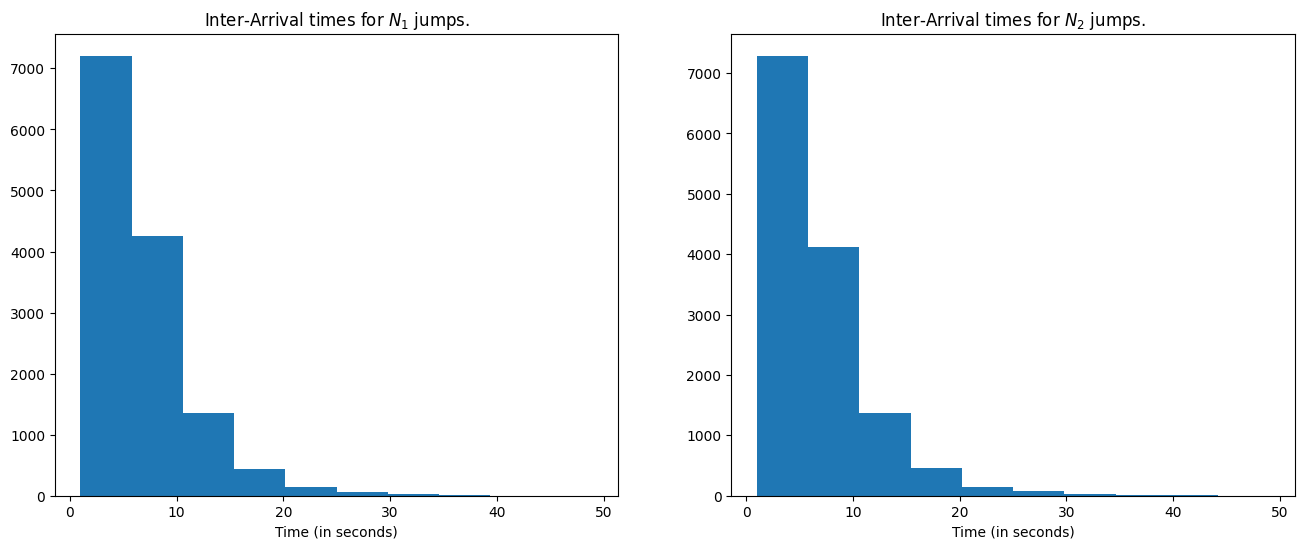

In [933]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].hist(np.diff(np.float64(num_jumps[num_jumps > 0].reset_index().start_time))/10**9)
ax[0].set_title('Inter-Arrival times for $N_1$ jumps.')
ax[0].set_xlabel('Time (in seconds)')

ax[1].hist(np.diff(np.float64(num_jumps[num_jumps < 0].reset_index().start_time))/10**9)
ax[1].set_title('Inter-Arrival times for $N_2$ jumps.')
ax[1].set_xlabel('Time (in seconds)')

### Signature Plot

In [643]:
def signature(tau):
    price = np.log(data.close[::tau].to_numpy())
    return np.sum((price[1:] - price[:-1])**2) / data.close.shape[0]

In [972]:
T = 200

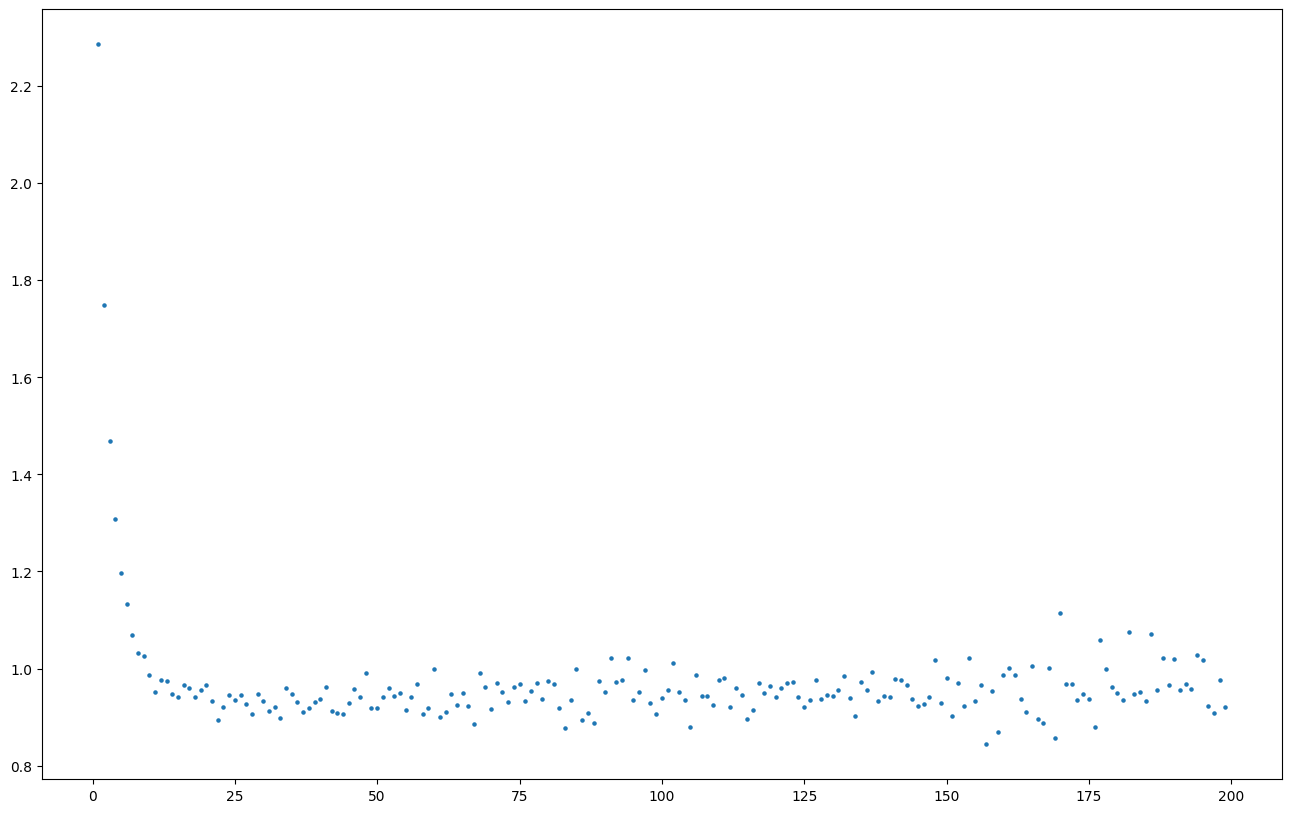

In [645]:
plt.figure(figsize=(16, 10))
plt.scatter(range(1, T), np.array([signature(tau) for tau in range(1, T)]) / signature(60), s=5)

In [646]:
def theo_signature(tau, mu, kappa, beta):
    lamda = 2*mu/(1-kappa)
    k = 1/(1 + kappa)
    gamma = beta*(kappa + 1)
    return lamda * (k**2 + (1-k**2) * (1-np.exp(-gamma * tau)) / (gamma * tau))

In [647]:
signature_realization = np.array([signature(tau) for tau in range(1, T)])

In [648]:
loss_fn = lambda params: np.sqrt(np.mean((signature_realization/signature_realization[10] - theo_signature(np.arange(1, T), params[0], params[1], params[2]))**2))

In [666]:
res = minimize(loss_fn, np.random.uniform(0, 1, 3), method= 'Nelder-Mead', bounds=[(1e-15, 10000), (1e-15, 1-1e-15), (1e-15, 1000)])
loss_fn(res.x), res.x

(0.05048972956956996, array([4.41452841e-05, 9.99977289e-01, 9.37855439e-01]))

In [602]:
mu = res.x[0]
kappa = res.x[1]
beta = res.x[2]
alpha = kappa * beta
print('mu =', mu)
print('alpha =', alpha)
print('beta =', beta)

mu = 0.03733820392040328
alpha = 0.9133214246722275
beta = 0.9315676185039614


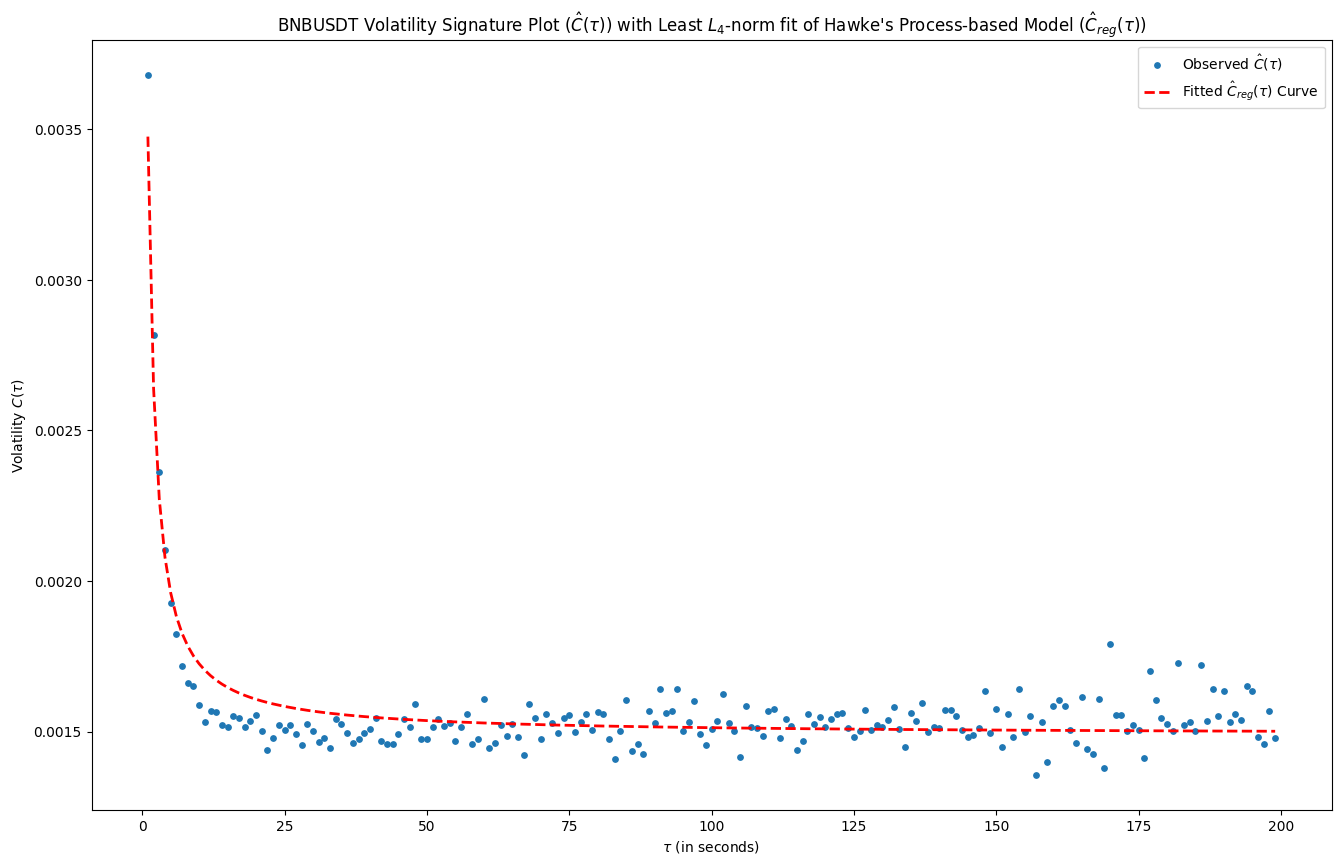

In [611]:
plt.figure(figsize=(16, 10))
plt.scatter(range(1, T), signature_realization, label=r'Observed $\hat{C}(\tau)$', s = 15)
plt.plot(range(1, T), signature_realization[10] * theo_signature(np.arange(1, T), res.x[0], res.x[1], res.x[2]), '--', 
         label=r'Fitted $\hat{C}_{reg}(\tau)$ Curve', color = 'red', linewidth=2)
plt.legend()
plt.title(r"BNBUSDT Volatility Signature Plot ($\hat{C}(\tau)$) with Least $L_4$-norm fit of Hawke's Process-based Model ($\hat{C}_{reg}(\tau)$)")
plt.xlabel(r'$\tau$ (in seconds)')
plt.ylabel(r'Volatility $C(\tau)$')
plt.show()

In [612]:
phi = lambda t: alpha * np.exp(-beta * t) * (t >= 0)

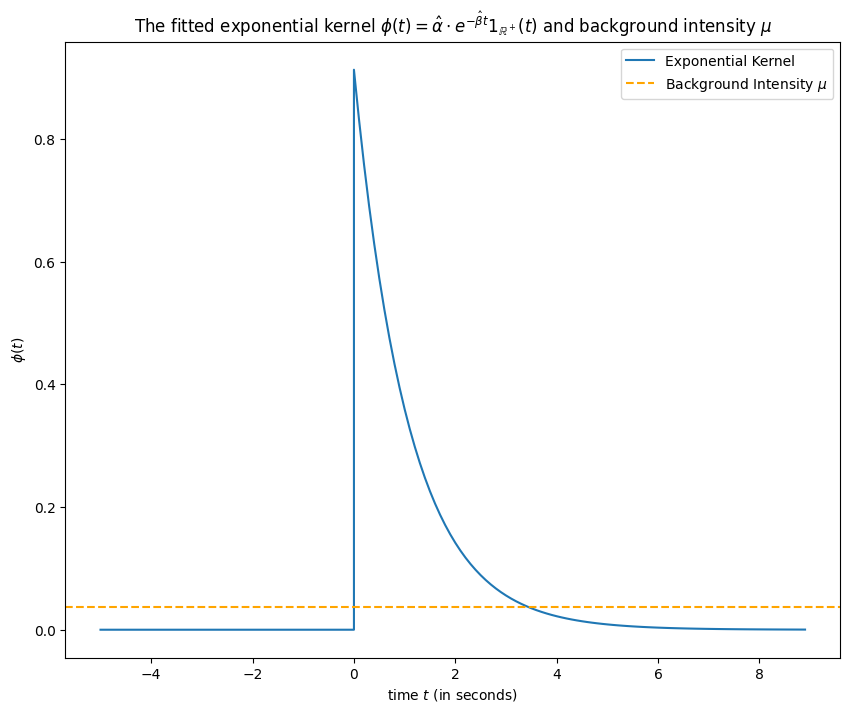

In [642]:
plt.figure(figsize=(10, 8))
plt.plot(list(range(-5, 1)) + list(np.arange(0, 9, 0.1)), [0] * 6 + list(phi(np.arange(0, 9, 0.1))), label='Exponential Kernel')
plt.axhline(mu, color='orange', linestyle='dashed', label='Background Intensity $\mu$')
plt.legend()
plt.title(r'The fitted exponential kernel $\phi(t) = \hat{\alpha}\cdot e^{-\hat{\beta} t}1_{\mathbb{R}^+}(t)$ and background intensity $\mu$')
plt.xlabel('time $t$ (in seconds)')
plt.ylabel('$\phi(t)$')
plt.show()

In [770]:
(data.close.diff().to_numpy()[1:]*10).astype(int)

array([0, 0, 0, ..., 0, 0, 0])

In [773]:
jumps = np.round(data.close.diff().to_numpy() * 10).astype(int)
jumps[:10]

/var/folders/mg/l90d6s9536n6mfzjbqgrxffm0000gn/T/ipykernel_61568/226064352.py:1: RuntimeWarning: invalid value encountered in cast
  jumps = np.round(data.close.diff().to_numpy() * 10).astype(int)


array([ 0,  0, -1,  0,  1, -1,  0,  0,  0,  1])

In [774]:
np.unique(jumps)

array([-6, -5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6, 13])

In [781]:
(4-1) + np.arange(4-1, 4, 1/(1+1))[1:]

array([6.5])

In [783]:
N1_jump_times_unraveled = list()
N2_jump_times_unraveled = list()

In [784]:
for i, jump in enumerate(jumps):
    if jump > 0:
        N1_jump_times_unraveled.extend(list(np.arange(i-1, i, 1/(jump+1))[1:]))
    elif jump < 0:
        N2_jump_times_unraveled.extend(list(np.arange(i-1, i, 1/(abs(jump)+1))[1:]))

In [787]:
N2_jump_times_unraveled = np.array(N2_jump_times_unraveled)
N1_jump_times_unraveled = np.array(N1_jump_times_unraveled)

Text(0.5, 0.98, 'The BNBUSDT Intensity Function of $N_1$ and $N_2$ for the first $20$ seconds on $30^{th}$ October 2024')

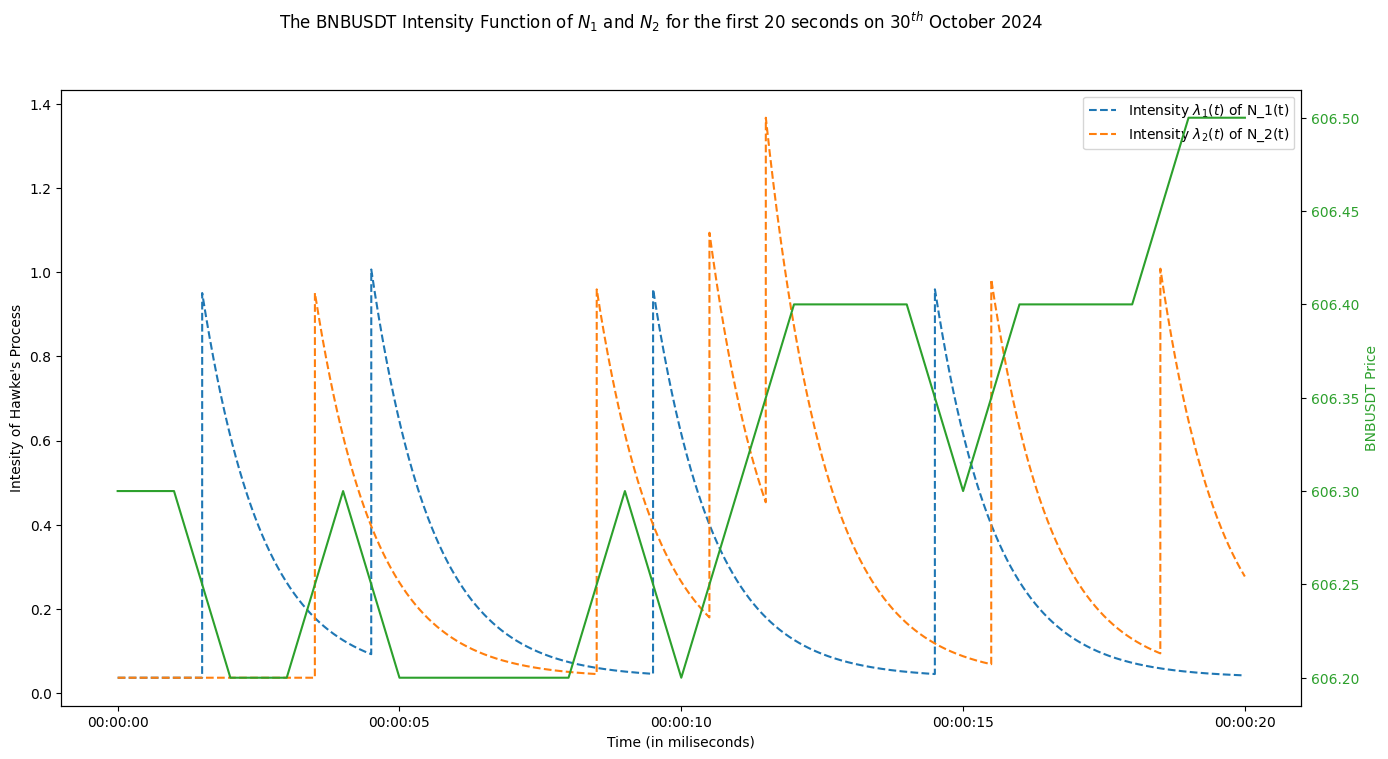

In [969]:
fig, ax1 = plt.subplots(figsize=(16, 8)) 
# plt.plot(data.close[:21])
ax1.plot(
    [data.close.index[0] + pd.Timedelta(t, 's') for t in np.arange(0, 20, 0.001)], 
    [mu + np.sum([phi(t-s) for s in N2_jump_times_unraveled[N2_jump_times_unraveled <= t]]) for t in np.arange(0, 20, 0.001)],
    '--',
    label='Intensity $\lambda_1(t)$ of N_1(t)')
ax1.plot(
    [data.close.index[0] + pd.Timedelta(t, 's') for t in np.arange(0, 20, 0.001)],
    [mu + np.sum([phi(t-s) for s in N1_jump_times_unraveled[N1_jump_times_unraveled <= t]]) for t in np.arange(0, 20, 0.001)],
    '--',
    label='Intensity $\lambda_2(t)$ of N_2(t)')
ax1.legend()
ax1.set_xlabel('Time (in miliseconds)')
ax1.set_ylabel("Intesity of Hawke's Process")

ax2 = ax1.twinx() 
 
color = 'tab:green'
ax2.set_ylabel('BNBUSDT Price', color = color) 
ax2.plot(data.close[:21], color = color) 
ax2.tick_params(axis ='y', labelcolor = color) 

fig.suptitle('The BNBUSDT Intensity Function of $N_1$ and $N_2$ for the first $20$ seconds on $30^{th}$ October 2024')

In [984]:
pred_probs = {
    0: list(),
    1: list(),
    2: list()
}

In [985]:
for t in tqdm(range(data.close.shape[0])):
    jump = jumps[:t]
    l1 = lambda forecast_t: mu + np.sum([phi(forecast_t-s) for s in N2_jump_times_unraveled[np.logical_and(N2_jump_times_unraveled <= t, N2_jump_times_unraveled >= t-5)]])
    l2 = lambda forecast_t: mu + np.sum([phi(forecast_t-s) for s in N1_jump_times_unraveled[np.logical_and(N1_jump_times_unraveled <= t, N1_jump_times_unraveled >= t-5)]])
    l1 = integrate.quad(l1, t, t+1)[0]
    l2 = integrate.quad(l2, t, t+1)[0]
    pred_probs[0].append(np.exp(-(l1+l2)) * np.sum([((l1 * l2)**k)/(np.math.factorial(k)) for k in range(20)]))
    pred_probs[1].append((1-pred_probs[0][-1]) * l1 / (l1 + l2))
    pred_probs[2].append((1-pred_probs[0][-1]) * l2 / (l1 + l2))

100%|██████████| 86400/86400 [01:08<00:00, 1252.23it/s]


In [987]:
pred_proba = pd.DataFrame(pred_probs)
pred_proba.index = data.index

In [988]:
pred_proba

,0,1,2
start_time,,,
2024-10-30 00:00:00,0.929338,0.035331,0.035331
2024-10-30 00:00:01,0.929338,0.035331,0.035331
2024-10-30 00:00:02,0.649015,0.321707,0.029278
2024-10-30 00:00:03,0.806774,0.160667,0.032559
2024-10-30 00:00:04,0.627238,0.070212,0.302549
...,...,...,...
2024-10-30 23:59:55,0.806774,0.032559,0.160667
2024-10-30 23:59:56,0.878977,0.034091,0.086932
2024-10-30 23:59:57,0.909164,0.034795,0.056041


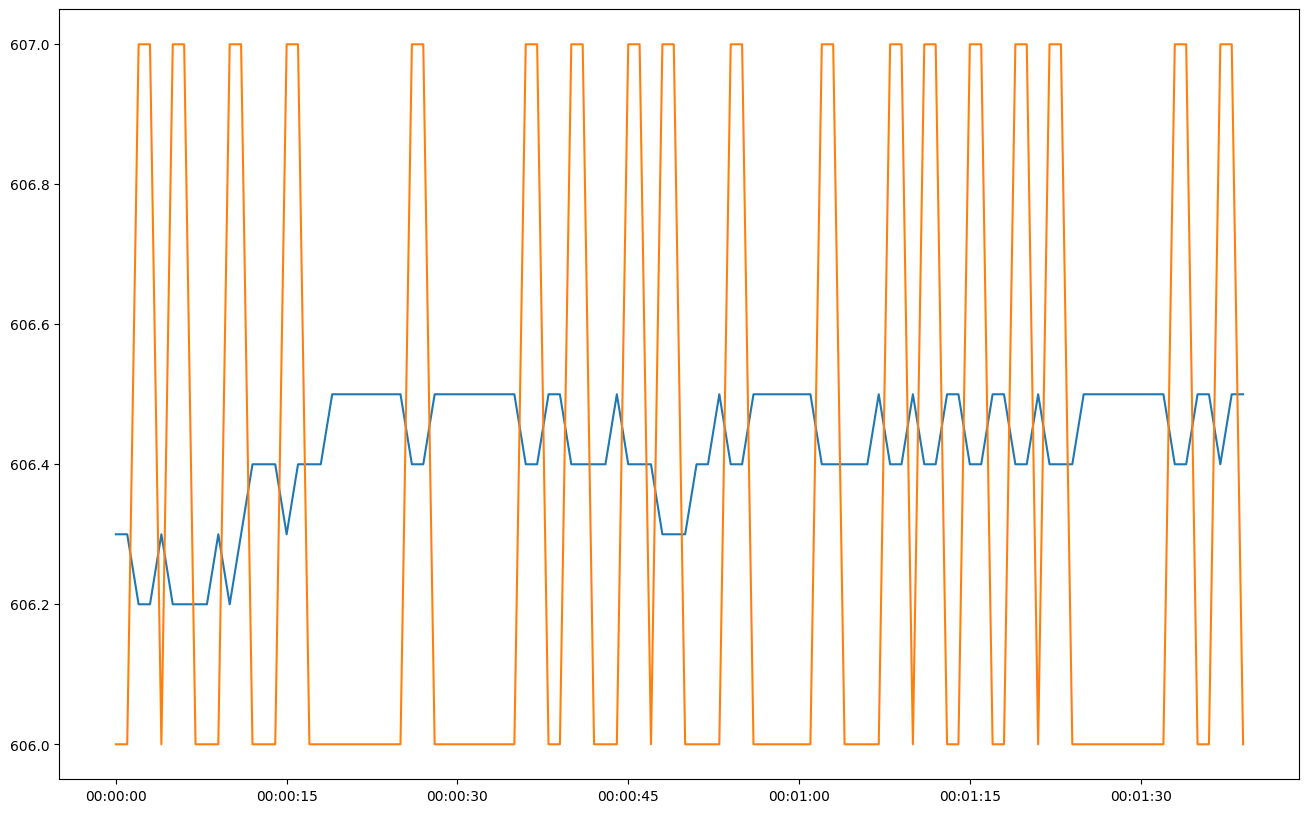

In [989]:
plt.figure(figsize=(16, 10))
plt.plot(data.close[:100])
plt.plot((pred_proba.iloc[:100, 1] >=0.10) + 606)
# plt.plot(pred_proba.iloc[:100, 2] + 606)
plt.show()

In [990]:
pred_proba

,0,1,2
start_time,,,
2024-10-30 00:00:00,0.929338,0.035331,0.035331
2024-10-30 00:00:01,0.929338,0.035331,0.035331
2024-10-30 00:00:02,0.649015,0.321707,0.029278
2024-10-30 00:00:03,0.806774,0.160667,0.032559
2024-10-30 00:00:04,0.627238,0.070212,0.302549
...,...,...,...
2024-10-30 23:59:55,0.806774,0.032559,0.160667
2024-10-30 23:59:56,0.878977,0.034091,0.086932
2024-10-30 23:59:57,0.909164,0.034795,0.056041


In [1008]:
THRESH = 0.8
pred_times = pred_proba[pred_proba.iloc[:, 0] <= THRESH].iloc[:, 1:].index + pd.Timedelta(seconds=1)
pred = np.argmax(pred_proba[pred_proba.iloc[:, 0] <= THRESH].iloc[:, 1:], 1)
actual = data.close.diff()[pred_times].to_numpy()
actual[actual == 0] = -1
actual[actual > 0] = 0
actual[actual < 0] = 1
actual = np.round(actual).astype(int)
np.mean(pred == actual)

0.6414022042225468

In [970]:
data_test = pd.read_csv("../data/BNBUSDT-1s-2024-10-31.csv", names=['start_time', 'open', 'high', 'low', 'close', 'vol', 'stop_time', 'quote_asset_vol', 'num_trades', 'taker_base_vol', 'taker_quote_vol', 'ignore'])
data_test = data_test.loc[:, 'start_time':'vol']
data_test['start_time'] = pd.to_datetime(data_test['start_time'], unit='ms')
data_test.set_index('start_time', inplace=True)
data_test

,open,high,low,close,vol
start_time,,,,,
2024-10-31 00:00:00,595.5,595.5,595.4,595.5,10.783
2024-10-31 00:00:01,595.4,595.5,595.4,595.5,0.188
2024-10-31 00:00:02,595.5,595.5,595.5,595.5,0.017
2024-10-31 00:00:03,595.5,595.5,595.5,595.5,0.033
2024-10-31 00:00:04,595.5,595.5,595.5,595.5,1.611
...,...,...,...,...,...
2024-10-31 23:59:55,576.5,576.5,576.5,576.5,0.537
2024-10-31 23:59:56,576.5,576.5,576.5,576.5,0.000
2024-10-31 23:59:57,576.5,576.5,576.5,576.5,0.152


In [971]:
def signature(tau):
    price = np.log(data_test.close[::tau].to_numpy())
    return np.sum((price[1:] - price[:-1])**2) / data_test.close.shape[0]

In [973]:
T = 200

In [974]:
signature_realization = np.array([signature(tau) for tau in range(1, T)])

In [975]:
loss_fn = lambda params: np.sqrt(np.mean((signature_realization/signature_realization[10] - theo_signature(np.arange(1, T), params[0], params[1], params[2]))**2))

In [977]:
res1 = minimize(loss_fn, np.random.uniform(0, 1, 3), method= 'Nelder-Mead', bounds=[(1e-15, 10000), (1e-15, 1-1e-15), (1e-15, 1000)])
loss_fn(res1.x), res1.x

(0.061191010346835696, array([0.05339182, 0.97334189, 1.74926956]))

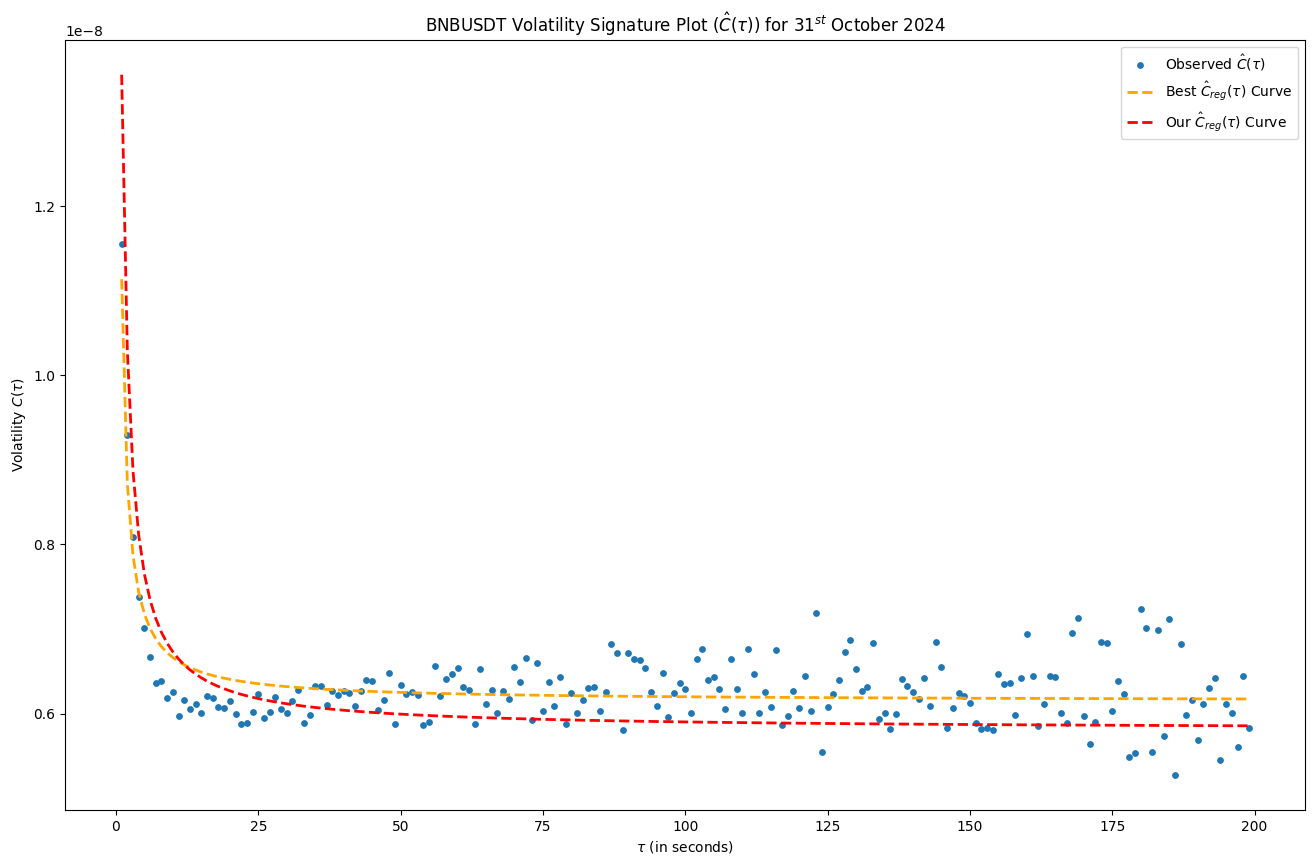

In [982]:
plt.figure(figsize=(16, 10))
plt.scatter(range(1, T), signature_realization, label=r'Observed $\hat{C}(\tau)$', s = 15)
plt.plot(range(1, T), signature_realization[10] * theo_signature(np.arange(1, T), res1.x[0], res1.x[1], res1.x[2]), '--', 
         label=r'Best $\hat{C}_{reg}(\tau)$ Curve', color = 'orange', linewidth=2)
plt.plot(range(1, T), signature_realization[10] * theo_signature(np.arange(1, T), mu, alpha/beta, beta), '--', 
         label=r'Our $\hat{C}_{reg}(\tau)$ Curve', color = 'red', linewidth=2)
plt.legend()
plt.title(r"BNBUSDT Volatility Signature Plot ($\hat{C}(\tau)$) for $31^{st}$ October 2024")
plt.xlabel(r'$\tau$ (in seconds)')
plt.ylabel(r'Volatility $C(\tau)$')
plt.show()

In [976]:
loss_fn([mu, alpha/beta, beta])

0.08578200964249963